## The EDA of Physionet Data set regarding "A Large Scale 12 Lead Electrocardiogram Database for Arrhythmia Study 1.0.0"

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
import random
from scipy.signal import butter, filtfilt

### Getting the records in the notebook

In [76]:
dataset_path = r'..\a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0\WFDBRecords\\'
count = 0

In [82]:
def visualize_data(record,name):

    print(record.shape)
    # print(record.record_name)
    # print(record.__dict__)
    
    fig,axes = plt.subplots(12,1,figsize=(12,20))
    
    
    leads = ["I", "II", "III", "avR", "avF", "aVL", "V1", "V2", "V3", "V4", "V5", "V6"]
    
    for i, lead in enumerate(leads):
        axes[i].plot(record[:, i])
        axes[i].set_ylabel(lead)
        
    plt.legend(leads)
    plt.savefig(f'{name}{count}.png')
    plt.show()
    

In [42]:


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist_freq = 0.5 * fs
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a



500
(5000, 12)


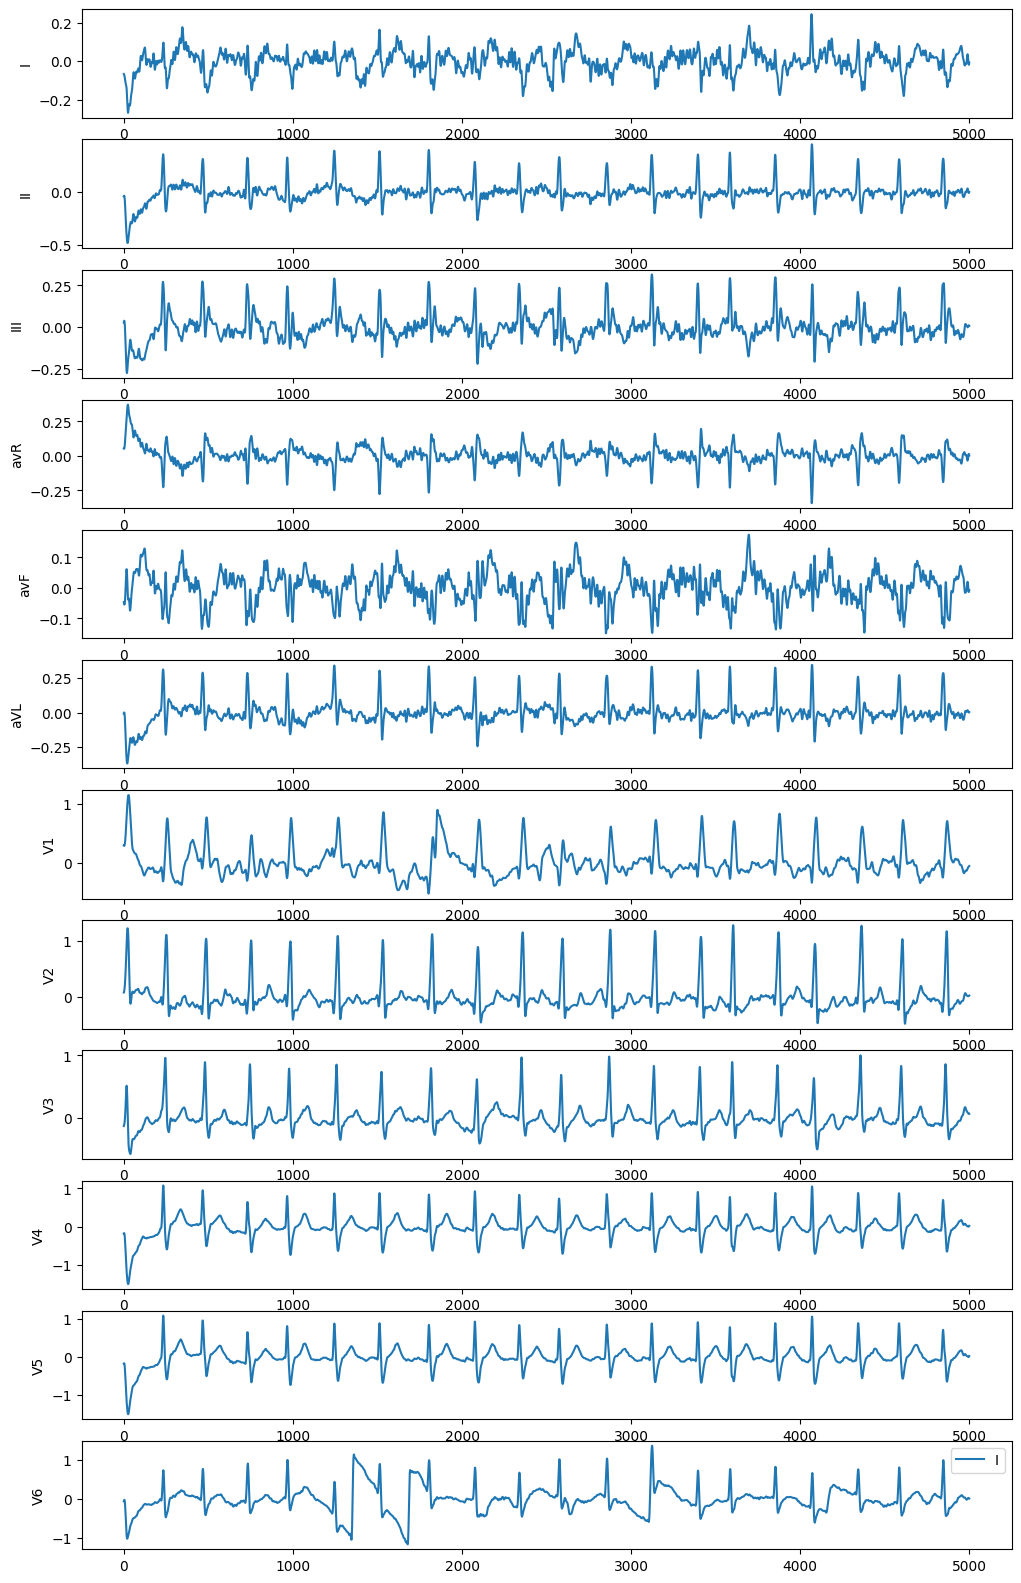

In [86]:
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Adjusted cutoff frequencies for normalized signal values
lowcut = 0.667  # Lower cutoff frequency in Hz
highcut = 40.0   # Higher cutoff frequency in Hz

print(record.fs)
filtered_p_signal = np.zeros_like(record.p_signal)

# Apply band-pass filter to each lead separately
for lead in range(12):
    filtered_signal = bandpass_filter(record.p_signal[:, lead], lowcut, highcut, record.fs)
    filtered_p_signal[:, lead] = filtered_signal

visualize_data(filtered_p_signal, "Normailzed")


(5000, 12)


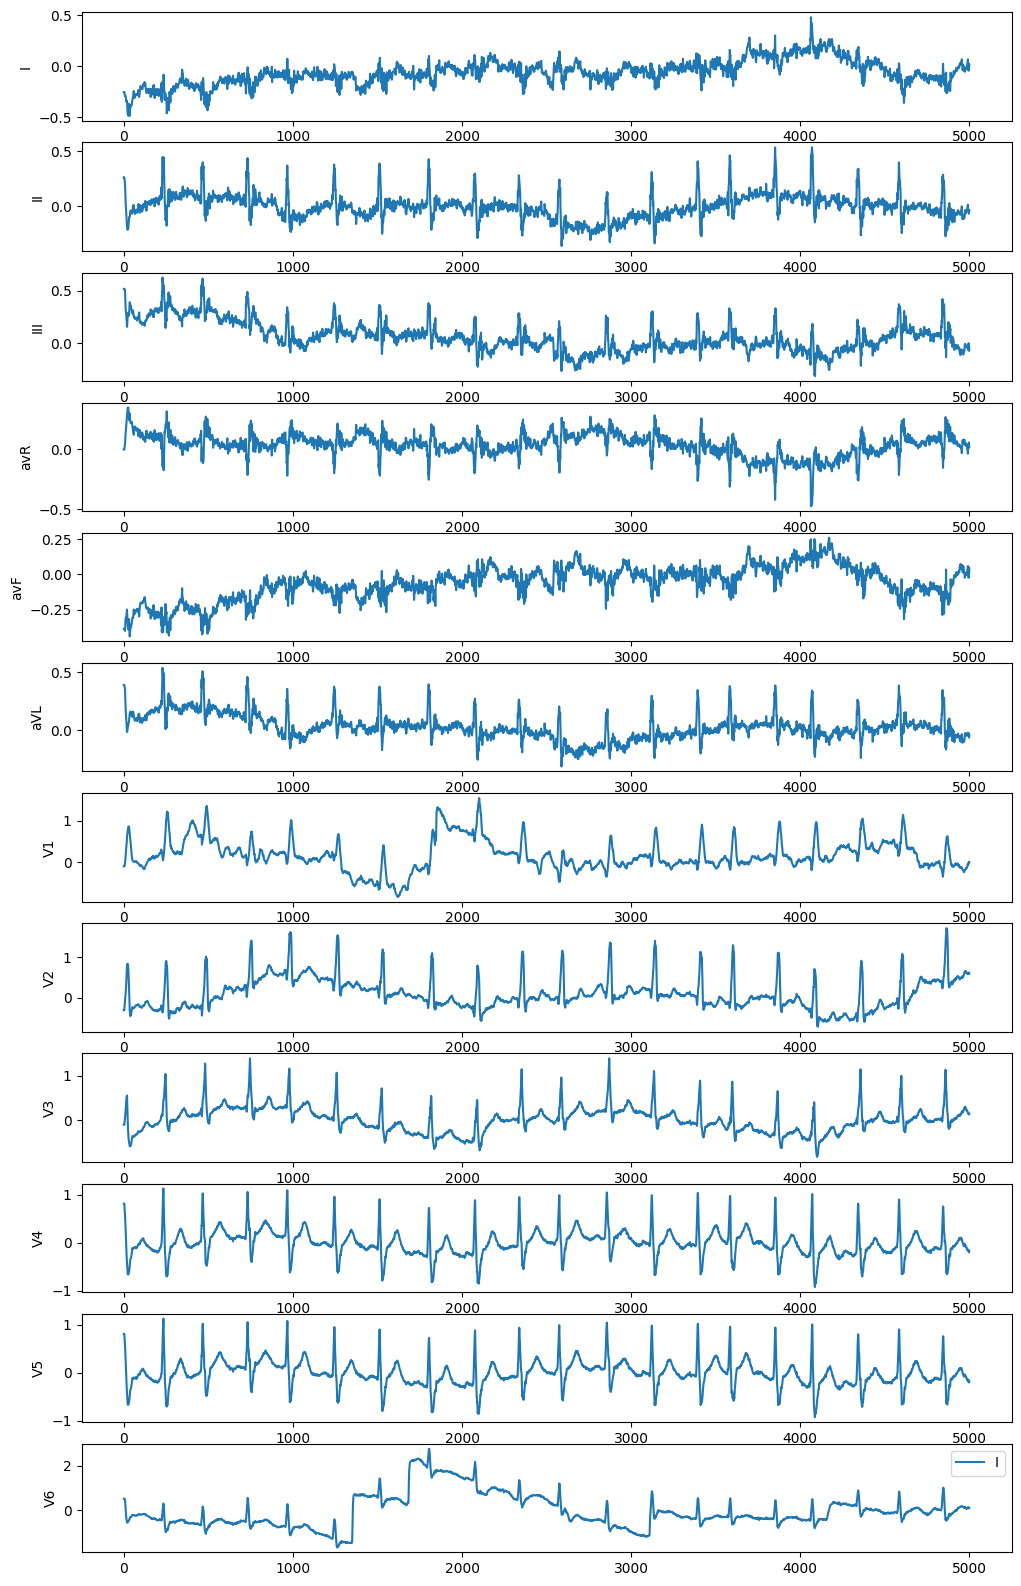

In [85]:

count = 0
record = None
# Initialize an empty DataFrame to hold the final result
final_df = None
# Loop through the first-level directories
for dir1 in os.listdir(dataset_path):
    dir1_path = os.path.join(dataset_path, dir1)
    
    # Loop through the subdirectories
    for dir2 in os.listdir(dir1_path):
        dir2_path = os.path.join(dir1_path, dir2)

        # Loop through the ECG records
        for file_name in os.listdir(dir2_path):
            if file_name.endswith('.mat'):
                file_path = os.path.join(dir2_path, file_name[:-4])
                count = count + 1
                if count < 2:
                    record = wfdb.rdrecord(file_path)
                    visualize_data(record.p_signal, "plot")
                else:
                    break
        # # Optionally, save the final DataFrame to a CSV file
        # final_df.to_csv()
        # final_df.drop(final_df.index, inplace=True)
        # final_df=None




## The Block to have commented out code:

# _, singular_values, _ = np.linalg.svd(record.p_signal)
    # print(np.count_nonzero(singular_values))
    # print(record.p_signal.T.shape)
    # print(np.linalg.matrix_rank(record.p_signal.T))
    
    # max(rank) = min(row, coulmns)
    
    # _, singular_values, _ = np.linalg.svd(record.p_signal.T)
    # print(np.count_nonzero(singular_values))
    
    
    
    #Printing the data set attribute p_signal to get the idea of the signal of ecg
    # print(record.record_name)
    # print(record.p_signal.shape)
    # print(type(record.p_signal))
    # print(np.sum(np.isnan(record.p_signal) | (record.p_signal == None)))
    # print(record.__dict__)
    # wfdb.plot_wfdb(record)
# visualize_ecg(dataset_path) 
